# Point this Project
Evaluate model classification to perform tweet sentiment Narendra Modi, use Naïve Bayes, SVM, KNN, LSTM, and BERT <br>

point bussiness
1. Filter word negative to goverment
2. Filter word on media social sentiment negative




In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from collections import Counter
from transformers import AutoModel, AutoTokenizer

import os
import re
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import json




2025-11-28 00:44:55 WARNI [dotenv.main] python-dotenv could not parse statement starting at line 4
2025-11-28 00:44:55 WARNI [dotenv.main] python-dotenv could not parse statement starting at line 6


True

In [124]:
from dotenv import load_dotenv
load_dotenv() 
groq_key = os.getenv("GROQ_API_KEY")

2025-11-28 00:46:09 WARNI [dotenv.main] python-dotenv could not parse statement starting at line 4
2025-11-28 00:46:09 WARNI [dotenv.main] python-dotenv could not parse statement starting at line 6


In [125]:
print(groq_key)

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


## Import data

In [18]:
df = pd.read_csv('Twitter_Data.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [20]:
text = df['clean_text'].head(1000).values.tolist()

number = 1
for i in text:
    print(f"{number}. {i}")
    number += 1

1. when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
2. talk all the nonsense and continue all the drama will vote for modi 
3. what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax
4. asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars
5. answer who among these the most powerful world leader today trump putin modi may 
6. kiya tho refresh maarkefir comment karo 
7. surat women perform yagna seeks divine grace for narendra modi become again

8. this comes from cabinet which has scholars like modi smriti and hema time introspect
9. with upcoming election india saga going important pair look current modi lead

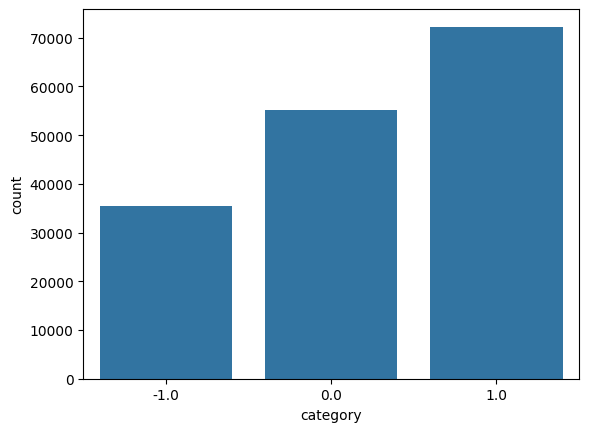

In [21]:
sns.countplot(x='category',data=df)
plt.show()

Feature Category merupakan labeling

## Preprocessing Data

In [22]:
print(f"Numbers of null ===================> \n{df.isnull().sum()}")
print(f"Numbers of duplicate ===================> {df.duplicated().sum()}")

Numbers of null ===================> 
clean_text    4
category      7
dtype: int64
Numbers of duplicate ===================> 1


In [23]:
#process data
df = df.dropna()
df = df.drop_duplicates()
print(f"Numbers of null ===================> \n{df.isnull().sum()}")
print(f"Numbers of duplicate ===================> {df.duplicated().sum()}")

Numbers of null ===================> 
clean_text    0
category      0
dtype: int64
Numbers of duplicate ===================> 0


In [24]:
def clean_data(df):
  df = df.dropna()
  df = df.drop_duplicates()
  return df

### Preprocess Link, lower str, tag

In [25]:
#remove space
df['clean_text'] = df['clean_text'].str.replace('\n',' ')
#change to lower str
df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())
#remove tag like - or _
df['clean_text'] = df['clean_text'].str.replace('-'," ").str.replace('_'," ")

#### Remove Emoji


In [26]:
text = []
#emoji pattern
emoji_pattern = r"[^\w\s,.!?-]"
#remove pattern �
pattern = r"\uFFFD"
for i in df['clean_text'].values.tolist():
    clean_text = re.sub(emoji_pattern, '', i)
    clean_text = re.sub(pattern, '', clean_text)
    text.append(clean_text)


In [27]:
def preprocesss_word(df,columns) :
  #remove space
  df[columns] = df[columns].str.replace('\n',' ')
  #change to lower str
  df[columns] = df[columns].apply(lambda x: x.lower())
  #remove tag like - or _
  df[columns] = df[columns].str.replace('-'," ").str.replace('_'," ")
  #remove emoji
  text = []
  emoji_pattern = r"[^\w\s,.!?-]"
  #remove pattern �
  pattern = r"\uFFFD"
  for i in df['clean_text'].values.tolist():
      clean_text = re.sub(emoji_pattern, '', i)
      clean_text = re.sub(pattern, '', clean_text)
      text.append(clean_text)
  df['final_text'] = text
  return df

In [28]:
df['clean_text2'] = text

In [29]:
df.head(5)

,clean_text,category,clean_text2
0,when modi promised “minimum government maximum...,-1.0,when modi promised minimum government maximum ...
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp t...
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...


### StopWord

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # cleaning text dari noise khusus stop words
nltk.download('punkt_tab')

def tokenize_text(text):
    tokens = nltk.word_tokenize(text.lower())
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#remove stop word
def preprocess_text(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_token = []
    for token in words :
        if token not in stop_words:
            filtered_token.append(token)
    return ' '.join(filtered_token)


In [33]:
df['clean_text3'] = df['clean_text2'].apply(preprocess_text)

In [34]:
#change value use clasification
df['category'] = df['category'].astype(int)
category= {
    -1 : 'Negative',
    0 : 'Netral',
    1 : 'Positive'
}
df['category'] = df['category'].map(category)

## EDA

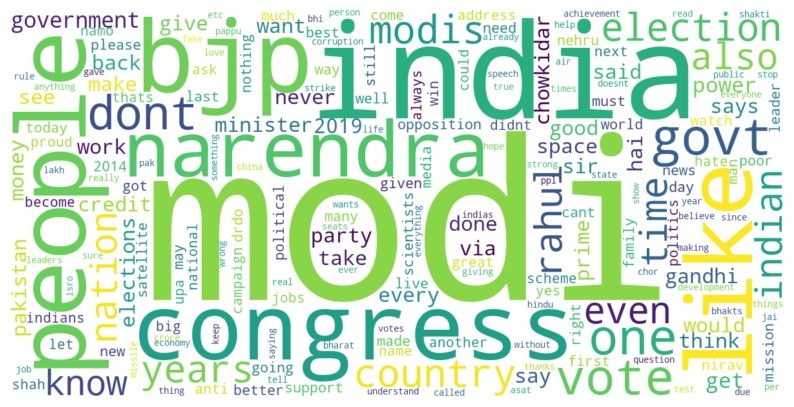

In [19]:

# Combine all preprocessed text into a single string
all_text = ' '.join(df['clean_text3'].astype(str))

# Tokenize the combined text into words
words = nltk.word_tokenize(all_text)

# Calculate word frequencies
word_frequencies = Counter(words)

wc = WordCloud(width=1200, height=600, background_color='white')
wc.generate_from_frequencies(word_frequencies)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Extraction

### Word2vec

In [169]:
from gensim.models import Word2Vec

# Tokenize each sentence into a list of words
sentence = [nltk.word_tokenize(i) for i in df['clean_text3'].values.tolist()]

model = Word2Vec(
    sentences=sentence,
    vector_size=500,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)
model.save('word2vec.model')

In [174]:
loaded_w2v_model = Word2Vec.load('word2vec.model')

def document_vector(model,doc_tokens):
    # hitung rata-rata vector 
    word_vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    
    if not word_vectors : 
        return np.zeros(model.vector_size)
    return np.mean(word_vectors,axis=0)


In [190]:
df['tokens'] = df['clean_text3'].apply(nltk.word_tokenize)

In [218]:
X = []
for tokens in df['tokens']:
    vec = document_vector(loaded_w2v_model,tokens)
    X.append(vec)
X = np.array(X)
y = df['category']

In [209]:
print(len(sentence))

162969


In [21]:
print(f"Vocabulary size: {len(model.wv.index_to_key)}")
print(model.wv.index_to_key[:50]) # Print first 50 words to avoid excessive output
# print(model.wv.most_similar('modi'))

Vocabulary size: 40525
['modi', 'india', 'bjp', 'people', 'congress', 'like', 'narendra', 'govt', 'vote', 'one', 'dont', 'country', 'modis', 'election', 'years', 'rahul', 'time', 'indian', 'nation', 'even', 'also', 'know', 'government', 'power', 'get', 'gandhi', 'want', 'minister', 'good', 'give', 'space', 'would', 'money', 'says', 'said', 'hai', 'see', 'done', 'credit', 'party', 'pakistan', 'sir', 'make', 'prime', 'every', 'think', 'say', 'take', 'back', 'via']


### google-bert/bert-base-multilingual-cased

In [22]:
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

def get_bert_embeddings(texts, tokenizer, model, max_len=128):
    """Fungsi untuk mendapatkan vektor [CLS] dari BERT"""
    model.eval()
    embeddings = []
    
    for text in texts:
        # Tokenisasi dan Encoding
        encoded_input = tokenizer(
            text, 
            padding='max_length', 
            truncation=True, 
            max_length=max_len, 
            return_tensors='pt'
        ).to(device)
        
        # Dapatkan Output dari BERT
        with torch.no_grad():
            output = model(**encoded_input)
            
        # Ekstraksi Vektor [CLS] (Representasi seluruh kalimat)
        # output[0] adalah hidden states dari layer terakhir
        # [:, 0, :] memilih token pertama, yaitu [CLS]
        cls_embedding = output[0][:, 0, :].cpu().numpy().flatten()
        embeddings.append(cls_embedding)
        
    return np.array(embeddings)

Mennggunakan model dari hugging face membutuhkan waktu 1 jam lebih, lebih baik menggunakan TFIDF yang memiliki kecepatan lebih baik

### TFIDF

In [35]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['clean_text3'])
y = df['category']


### SMOTE Category

In [219]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


## Classfication

In [220]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('sentiment_analysis_modi')

<Experiment: artifact_location='file:///d:/Python/dibimbing/final_project/research/mlruns/1', creation_time=1764076656630, experiment_id='1', last_update_time=1764076656630, lifecycle_stage='active', name='sentiment_analysis_modi', tags={}>

In [221]:
def evaluate_model(y_test,y_pred):
    return {
        "accuracy_score" : accuracy_score(y_test,y_pred),
        "precision" : precision_score(y_test,y_pred,average='weighted',zero_division=0),
        "recall" : recall_score(y_test,y_pred,average='weighted',zero_division=0),
        "f1_score" : f1_score(y_test,y_pred,average='weighted',zero_division=0)
    }

In [222]:
models = {
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C' : 10.0,
            'solver': 'saga',
            'max_iter': 200
        }
    },

    'naive_bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': 1.0
        }
    },

    'knn_classifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': 5,
            'weights': 'distance',
            'metric': 'euclidean',
        }
    },

    'random_forest_classifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': 100,
            'max_depth': 6,
            'min_samples_split': 2,
            'min_samples_leaf': 2,
            'random_state': 42
        }
    },
}


In [223]:
for model_name, model_info in models.items():
    with mlflow.start_run(run_name=model_name):
        # log model parameters
        mlflow.log_params(model_info['params'])
        
        # train model
        model = model_info['model'].set_params(**model_info['params'])
        model.fit(X_train, y_train)
        
        #make predictions
        y_pred= model.predict(X_test)
        
        
        
        #calculate metrics
        metrics = evaluate_model(y_test,y_pred)
        mlflow.log_metrics(metrics)
        
        # log model
        mlflow.sklearn.log_model(model,model_name,registered_model_name=f"{model_name}_model")
        
        print(f"\nModel: {model_name}")
        for metric_name, metric_value, in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")    
        

c:\Users\USER\anaconda3\envs\final_project\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2025/11/28 07:43:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 07:44:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'logistic_regression_model' already exists. Creating a new version of this model...
Created version '3' of model 'logistic_regression_model'.



Model: logistic_regression
accuracy_score: 0.6989
precision: 0.7002
recall: 0.6989
f1_score: 0.6986


ValueError: Negative values in data passed to MultinomialNB (input X).

## With Hyperamater Tuning

In [22]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('sentiment_analysis_modi_hyperamater')

2025/11/26 03:24:00 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/26 03:24:00 INFO mlflow.store.db.utils: Updating database tables
2025-11-26 03:24:00 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-26 03:24:00 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-26 03:24:00 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-26 03:24:00 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='file:///d:/Python/dibimbing/final_project/research/mlruns/2', creation_time=1764079961447, experiment_id='2', last_update_time=1764079961447, lifecycle_stage='active', name='sentiment_analysis_modi_hyperamater', tags={}>

In [23]:
models_tuning = {
    'Logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs'],
            'max_iter': [100, 200, 300]
        }
    },

    'Naive_bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0]
        }
    },

    'KNN_classifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },

    'Random_forest_classifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 6, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [42]
        }
    },
}


In [26]:
# grid search hyperparameter tuning
for model_name, model_info in models_tuning.items():
    with mlflow.start_run(run_name=f"{model_name}_Hyperparameter_Tuning") :
        
        
        grid_search= model_info['model'] 
        grid_search = GridSearchCV(estimator=model_info['model'],
                                param_grid=model_info['params'],
                                scoring='neg_mean_squared_error',
                                cv=5,
                                n_jobs=-1,
                                verbose=1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        
        mlflow.log_params(best_model.get_params())
        
        y_pred = best_model.predict(X_test)
        
        
        metrics = evaluate_model(y_test,y_pred)
        mlflow.log_metrics(metrics)
        #save log model
        mlflow.sklearn.log_model(best_model,model_name,registered_model_name=f"{model_name}_best_model")
        
        print(f"\nModel: {model_name} after Hyperparameter Tuning")
        for metric_name, metric_value, in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\USER\anaconda3\envs\dibimbing\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\USER\anaconda3\envs\dibimbing\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
2025/11/26 03:34:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/26 03:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/26 03:34:11 INFO mlflow.store.db.utils: Creating init


Model: Logistic_regression after Hyperparameter Tuning
accuracy_score: 0.8266
precision: 0.8381
recall: 0.8266
f1_score: 0.8258
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\USER\anaconda3\envs\dibimbing\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
2025/11/26 03:34:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/26 03:34:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Naive_bayes_best_model' already exists. Creating a new version of this model...
Created version '4' of model 'Naive_bayes_best_model'.



Model: Naive_bayes after Hyperparameter Tuning
accuracy_score: 0.7773
precision: 0.7868
recall: 0.7773
f1_score: 0.7769
Fitting 5 folds for each of 16 candidates, totalling 80 fits


PicklingError: Could not pickle the task to send it to the workers.

## Load model Mlflow

In [ ]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
def load_production_model(model_name):
    model = mlflow.sklearn.load_model(f"models:/{model_name}_model/Production")
    return model
def load_production_hyperparameter_model(model_name):
    model = mlflow.sklearn.load_model(f"models:/{model_name}_best_model/Production")
    return model

In [44]:
model = load_production_model('logistic_regression')

input = "modi is the worst leader ever"

output = model.predict(tfidf_vectorizer.transform([input]))

if output == 'Negative':
    print("i'm sorry i cannot help you with that")
else :
    print(output)

i'm sorry i cannot help you with that


## Build LLM Model

In [3]:
from haystack import Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
import requests



In [149]:
PROMPT_TEMPLATE = """
You are a helpful and friendly assistant. 
Please provide a concise and general answer to the following question:

{% if category == "Negative" %}
    respond i'm sorry i cannot help you with that
{% else %}
    answer the question based on the input below
{% endif %}

input : {{input}}

output :
"""

In [119]:
@component
class GroqLLM:
    def __init__(self, model_name="meta-llama/llama-4-maverick-17b-128e-instruct", api_key=None):
        self.api_key = api_key
        self.model_name = model_name

    @component.output_types(output=str)
    def run(self, prompt: str):
        url = "https://api.groq.com/openai/v1/chat/completions"
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }

        payload = {
            "model": self.model_name,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": 0.7,
            "max_tokens": 300
        }

        response = requests.post(url, headers=headers, json=payload)
        try:
            data = response.json()
        except Exception:
            raise ValueError("Gagal parse JSON dari Groq API: ", response.text)

        # Debug untuk melihat isi JSON asli
        if "choices" not in data:
            raise ValueError(
                "Groq API tidak mengembalikan 'choices'.\n"
                f"Status Code: {response.status_code}\n"
                f"Response JSON:\n{json.dumps(data, indent=2)}"
            )

        # Jika OK, ambil isi respon
        result = data["choices"][0]["message"]["content"]
        return {"output": result}

In [160]:
@component
class PredictionCategory:
    def __init__(self, model_name: str):
        mlflow.set_tracking_uri('sqlite:///mlflow.db')
        self.model = mlflow.sklearn.load_model(f"models:/{model_name}_model/Production")
    
    @component.output_types(category=str)
    def run(self, input_data):
        transform_tfidf = tfidf_vectorizer.transform([input_data])
        category = self.model.predict(transform_tfidf)
        return {"category" : category[0]}

In [162]:
groq_llm = GroqLLM(api_key=groq_key)
prediction_category = PredictionCategory(model_name='logistic_regression')
prompt_builder = PromptBuilder(
    template=PROMPT_TEMPLATE,
    required_variables=["input","category"],
)

pipeline = Pipeline()
pipeline.add_component("prediction", prediction_category)
pipeline.add_component("prompt_builder",prompt_builder)
pipeline.add_component("groq_llm",groq_llm)

pipeline.connect("prediction.category","prompt_builder.category")
pipeline.connect("prompt_builder","groq_llm")


🚅 Components
  - prediction: PredictionCategory
  - prompt_builder: PromptBuilder
  - groq_llm: GroqLLM
🛤️ Connections
  - prediction.category -> prompt_builder.category (str)
  - prompt_builder.prompt -> groq_llm.prompt (str)

In [163]:
prediction_category

prediction
Inputs:
  - input_data: _empty
Outputs:
  - category: str

In [167]:
user_input = "I Hate Modi because he is corrupt"

response = pipeline.run(
    {
        "prediction" : {
            "input_data" : user_input
        },
        "prompt_builder" : {
            "input" : user_input
        }
    }
)

In [168]:
print(response['groq_llm']['output'])

I'm sorry, I cannot help you with that.


## Create Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'clean_text3')
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression())
])